## Load the Time Series Data

In [27]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Load the time series data from a CSV file
data_set = pd.read_csv('Train.csv')

In [28]:
data_set.shape

(18288, 3)

In [29]:
data_set.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [30]:
data_set.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [31]:
# Function to do some processing
def processing(df):
    # Attempt to parse the 'Datetime' column with the first format
    try:
        df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
    except ValueError:
        # If the first format fails, try the second format
        df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H:%M')
    
    df.set_index('Datetime', inplace=True)
    df = df.resample('D').mean()
    df.drop('ID', axis=1, inplace=True)
    return df

In [32]:
data_set = processing(data_set)
timeseries = data_set[["Count"]].values.astype('float32')
data_set.head()

,Count
Datetime,
2012-08-25,3.166667
2012-08-26,3.666667
2012-08-27,2.583333
2012-08-28,2.416667
2012-08-29,2.500000


In [33]:
# train-test split for time series
train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [34]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    Args:
    dataset: A numpy array of time series, first dimension is the time steps
    lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)



In [35]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x) 
        x = self.linear(x)
        return x



In [36]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
n_epochs = 3000

Epoch 0: train RMSE 90.7402, test RMSE 318.2934


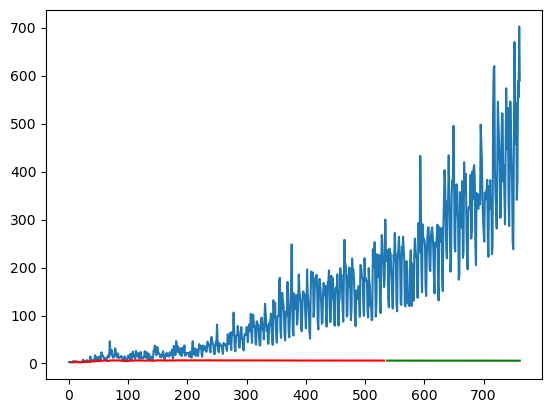

Epoch 100: train RMSE 29.8470, test RMSE 204.5080


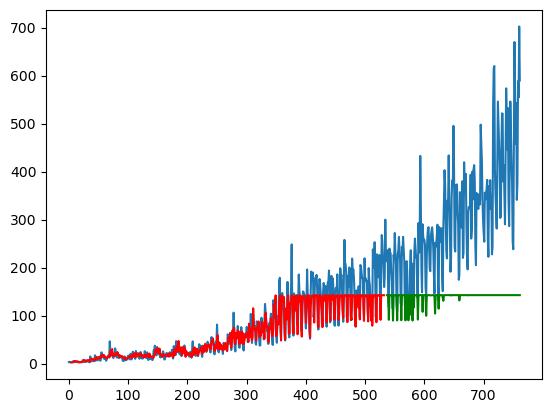

Epoch 200: train RMSE 24.4762, test RMSE 178.8674


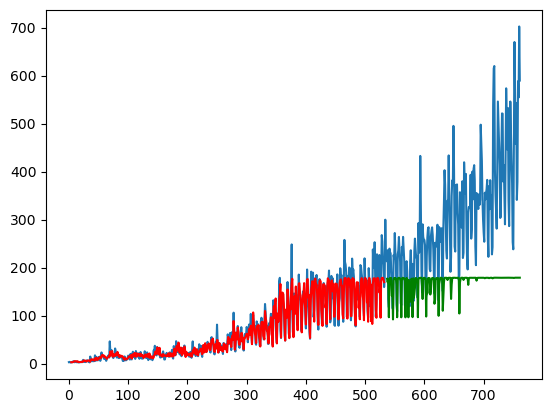

Epoch 300: train RMSE 22.6262, test RMSE 167.0715


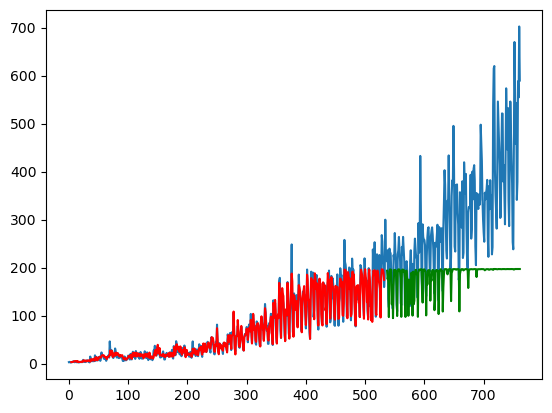

Epoch 400: train RMSE 21.3862, test RMSE 159.2344


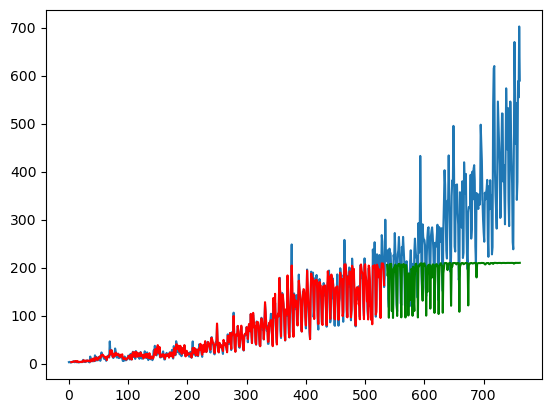

Epoch 500: train RMSE 20.6421, test RMSE 154.1475


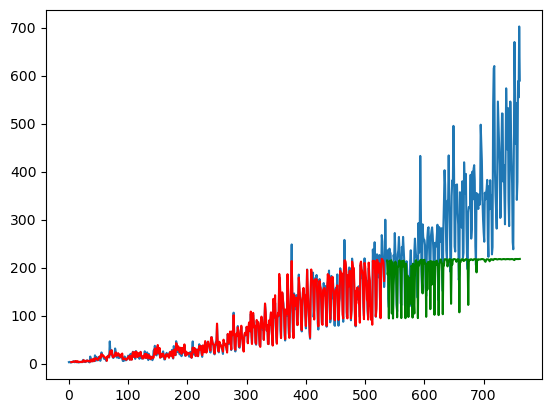

Epoch 600: train RMSE 20.3782, test RMSE 150.3116


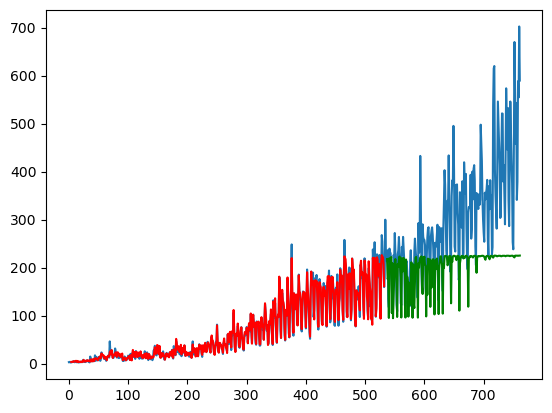

Epoch 700: train RMSE 19.7056, test RMSE 146.6378


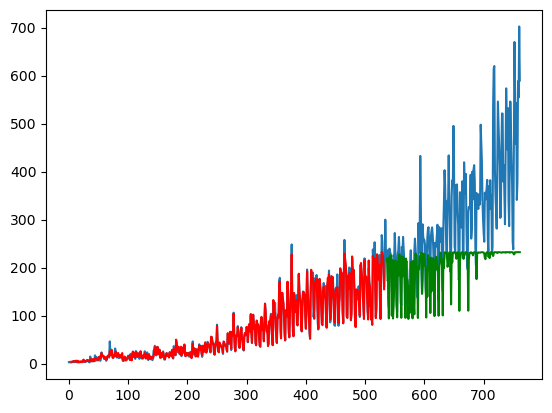

Epoch 800: train RMSE 19.4775, test RMSE 144.9841


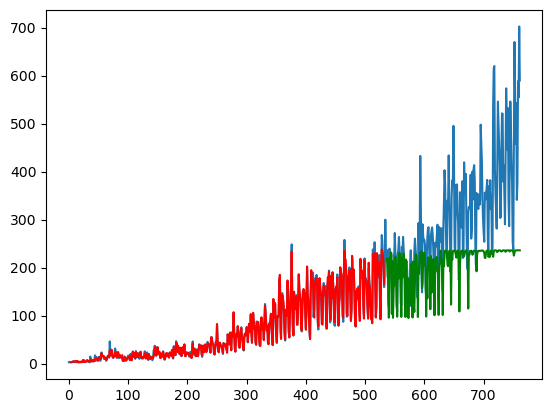

Epoch 900: train RMSE 19.0816, test RMSE 143.3272


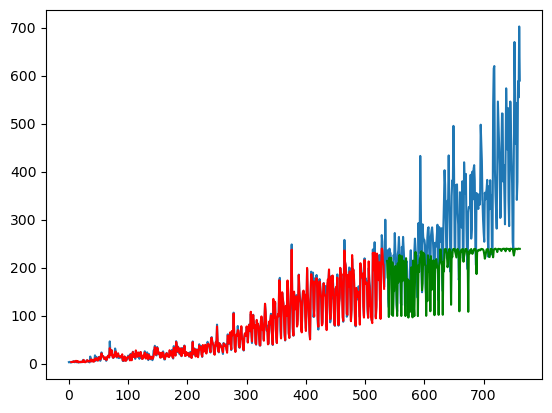

Epoch 1000: train RMSE 19.2305, test RMSE 142.0229


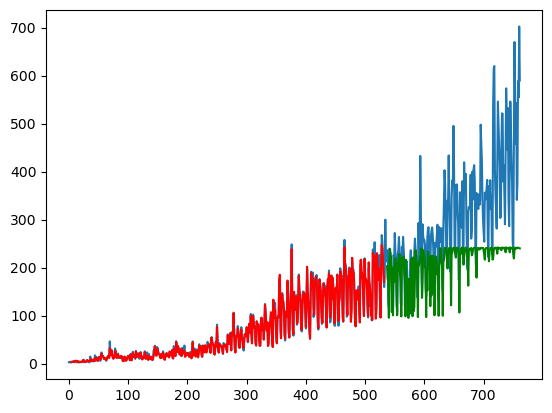

Epoch 1100: train RMSE 18.8362, test RMSE 140.2876


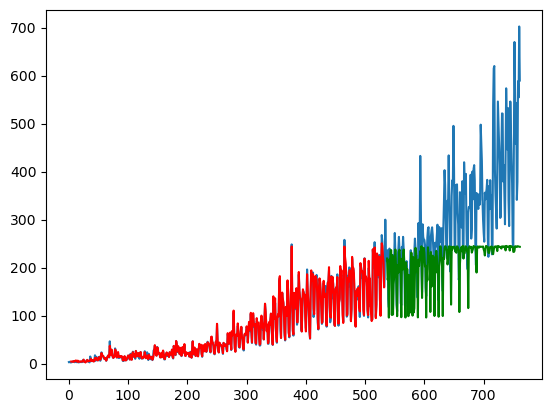

Epoch 1200: train RMSE 19.4209, test RMSE 141.3018


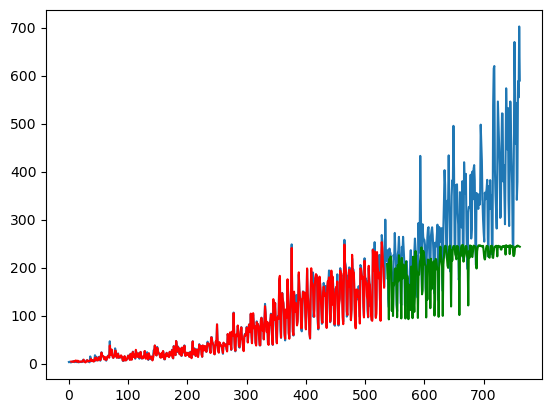

Epoch 1300: train RMSE 18.5773, test RMSE 138.7051


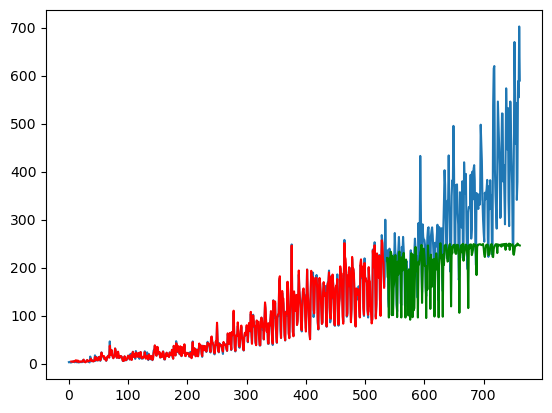

Epoch 1400: train RMSE 18.3134, test RMSE 140.0473


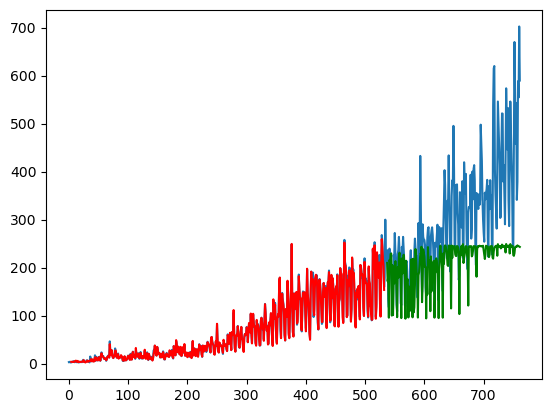

Epoch 1500: train RMSE 18.5250, test RMSE 139.3845


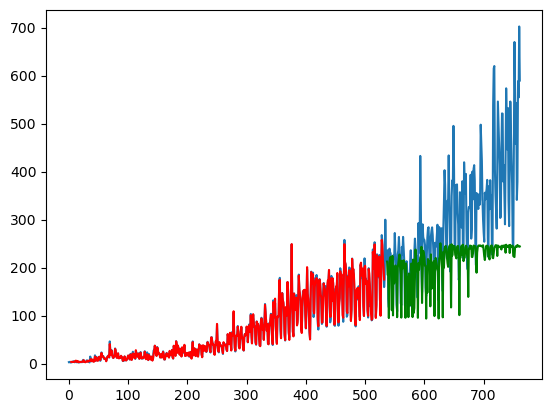

Epoch 1600: train RMSE 18.0154, test RMSE 139.2208


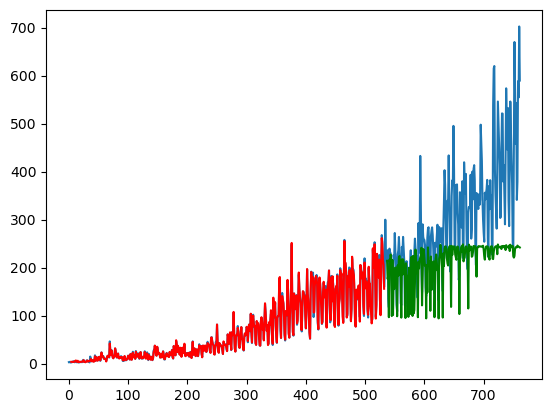

Epoch 1700: train RMSE 17.8618, test RMSE 138.8964


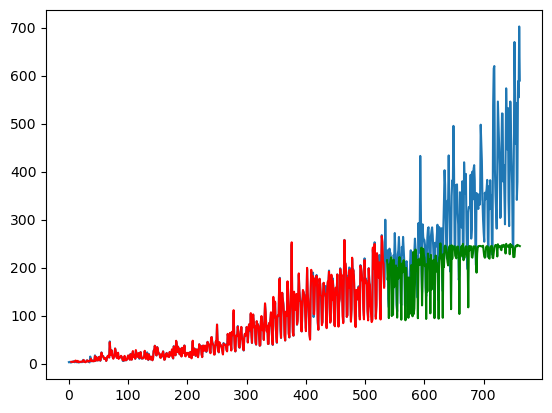

Epoch 1800: train RMSE 17.8035, test RMSE 137.3568


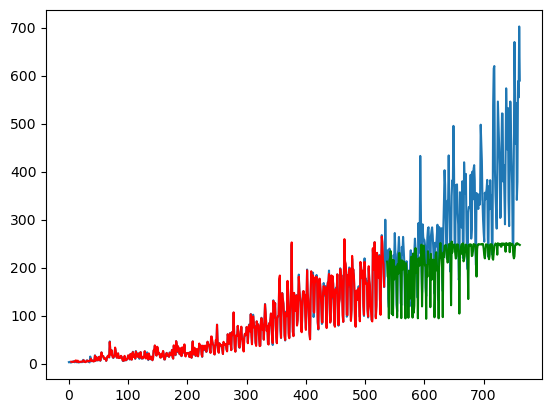

Epoch 1900: train RMSE 18.0868, test RMSE 138.3693


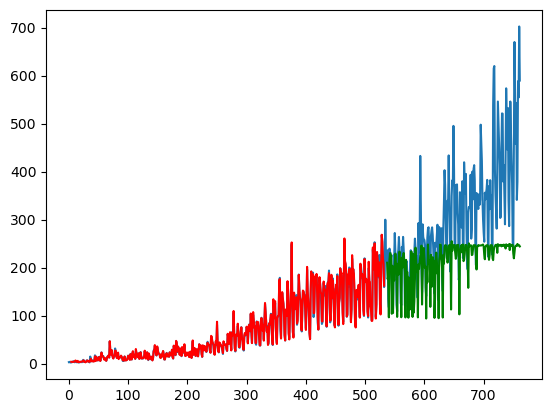

Epoch 2000: train RMSE 17.8578, test RMSE 138.1316


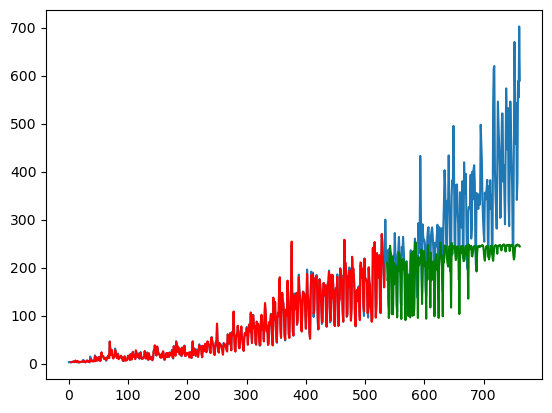

Epoch 2100: train RMSE 17.4504, test RMSE 137.6058


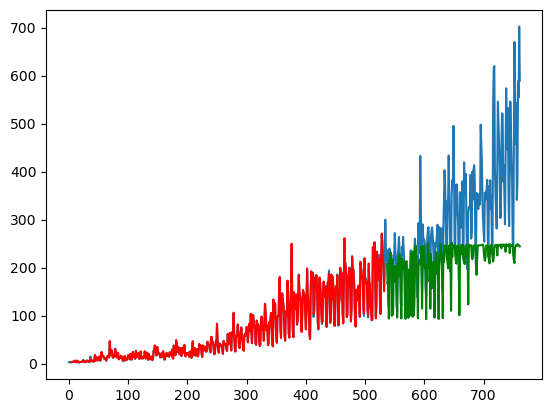

Epoch 2200: train RMSE 17.5207, test RMSE 137.9758


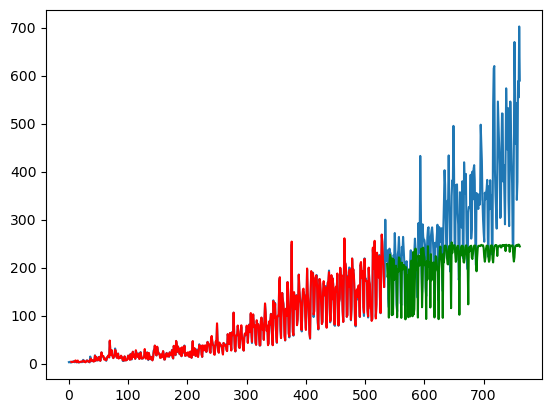

Epoch 2300: train RMSE 17.6027, test RMSE 139.0120


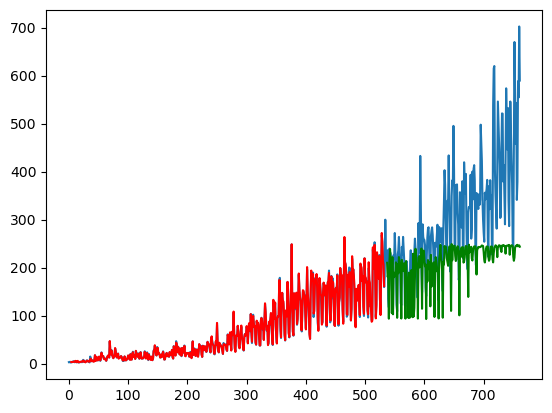

Epoch 2400: train RMSE 17.4929, test RMSE 137.2987


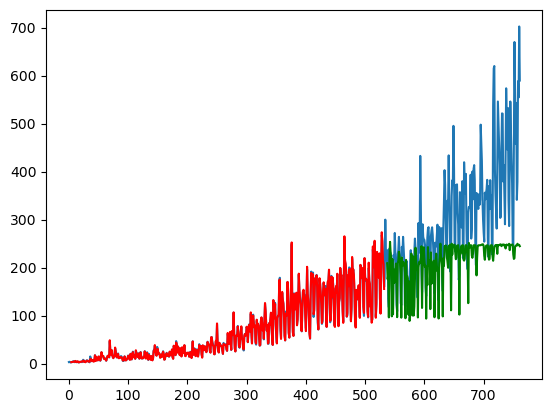

Epoch 2500: train RMSE 17.2648, test RMSE 138.4785


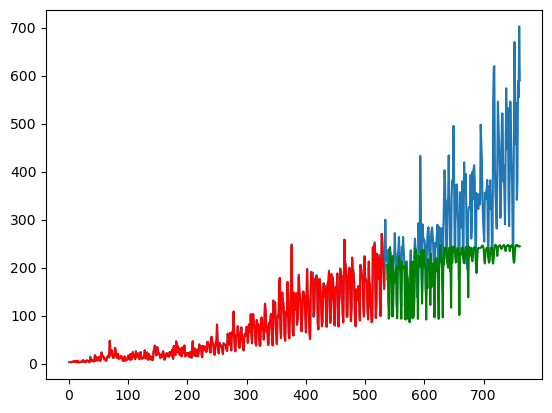

Epoch 2600: train RMSE 17.9168, test RMSE 138.6361


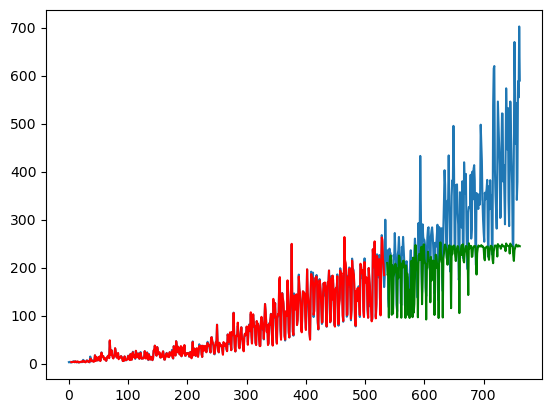

Epoch 2700: train RMSE 17.1615, test RMSE 138.7212


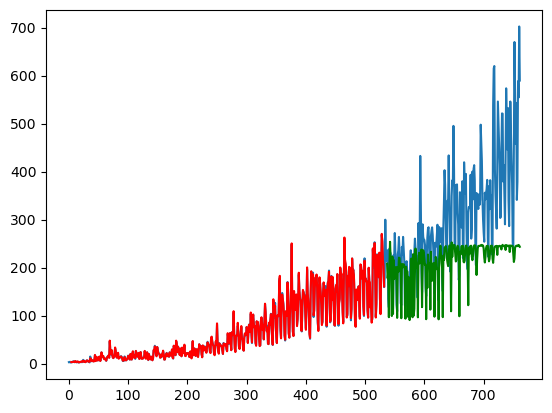

Epoch 2800: train RMSE 17.2486, test RMSE 138.3432


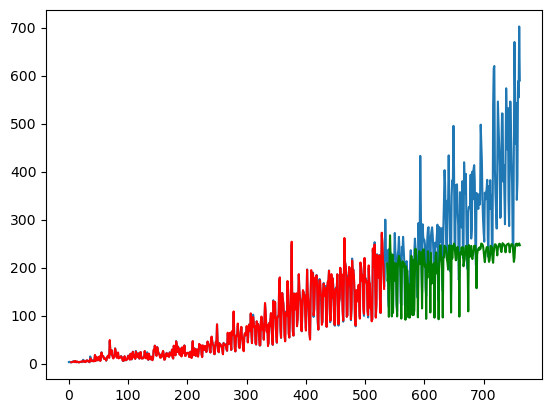

Epoch 2900: train RMSE 17.1317, test RMSE 139.0165


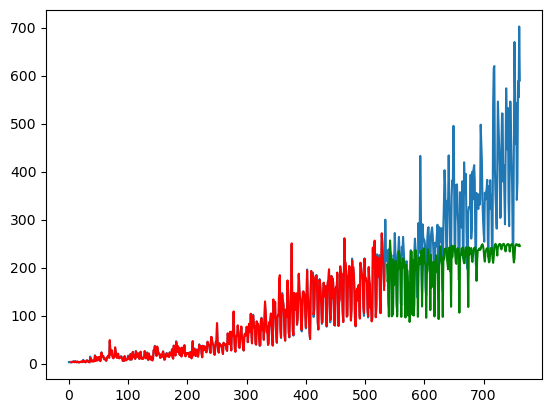

In [37]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 100 != 0:
        continue

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    with torch.no_grad():
        # shift train predictions for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1, :]
        train_plot[lookback:train_size] = model(X_train)[:, -1, :]

        # shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

        # plot
        plt.plot(timeseries)
        plt.plot(train_plot, c='r')
        plt.plot(test_plot, c='g')
        plt.show()